In [2]:
using DifferentialEquations, SciMLBase, Plots, Random, DataStructures, DelimitedFiles, XLSX
using LatinHypercubeSampling
using JLD2

include("./EDES/including.jl")
include("./DataGeneration/AnalyseSynths/SyntheticPatients.jl")
include("./DataGeneration/DiseaseProgression/DiseaseProgression.jl")
include("./DataGeneration/AnalyseSynths/LocalSensitivity.jl")

# Set the seed for reproducibility
Random.seed!(1234)

TaskLocalRNG()

In [3]:
n = 10
parameters = ["k5","k6"]
BW = 70

means_params = [0.0174, 4.6237]


lower_deviation = means_params .- (means_params .*0.1)
higher_deviation = means_params .+ (means_params .* 0.1)


# deviation_NutriTech = std_NutriTech ./ means_NutriTech

# lower_deviation = means_NutriTech .- (means_NutriTech .* deviation_NutriTech*0.1)
# higher_deviation = means_NutriTech .+ (means_NutriTech .* deviation_NutriTech*0.1)

parameter_ranges = OrderedDict( "k5" => (lower_deviation[1], higher_deviation[1]), 
                    "k6" => (lower_deviation[2], higher_deviation[2]))
fasting_ranges = OrderedDict("fasting_glucose" => (4.8,5.2), 
                        "fasting_insulin" => (7.5, 12),)
Synthetic_population = MakePatients(n, parameters, parameter_ranges, fasting_ranges, BW = BW);

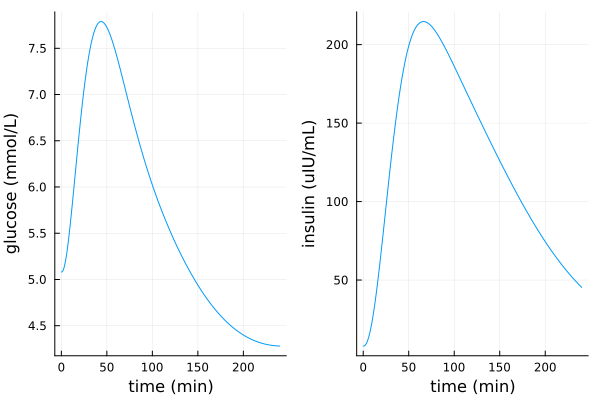

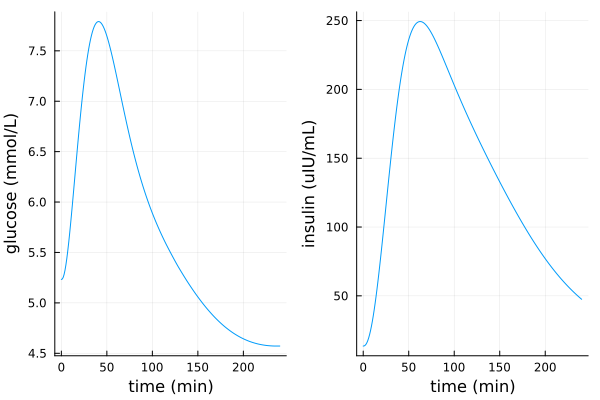

[0.017399999998260002, 4.25380400323659, 5.079999997800001, 7.950000005550001]
[0.016181999998381803, 4.806798523657347, 5.232399997734001, 13.515000009435001]
[0.013745999998625401, 5.40233108411047, 5.537199997602001, 24.645000017205]
[0.011309999998869, 5.317255004045737, 5.841999997470001, 35.775000024975]
[0.0100919999989908, 5.019488723819176, 5.994399997404001, 41.34000002886]
[0.0076559999992344, 3.9134996829776627, 6.299199997272001, 52.470000036630005]
[0.006437999999356198, 3.1052769223627106, 6.451599997206001, 58.03500004051501]


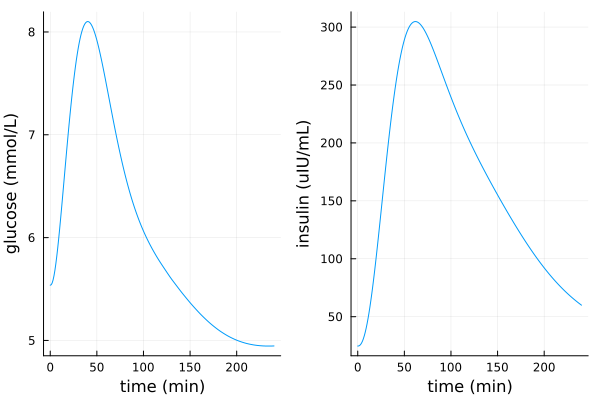

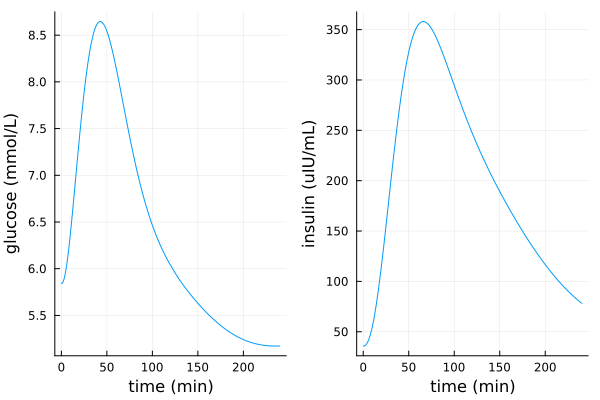

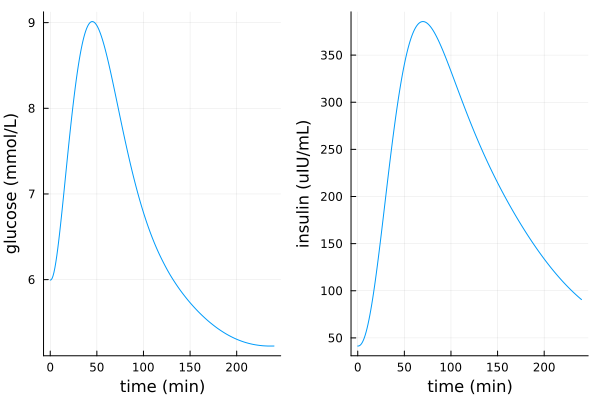

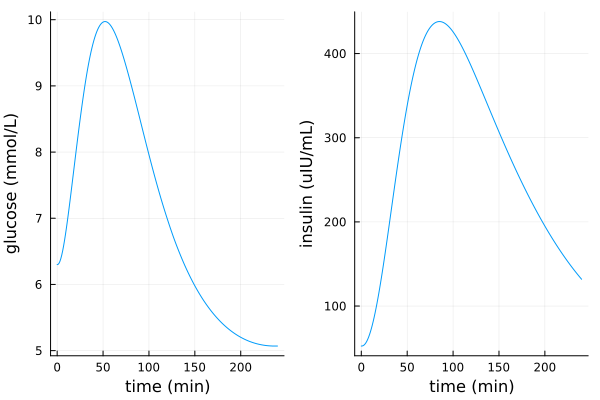

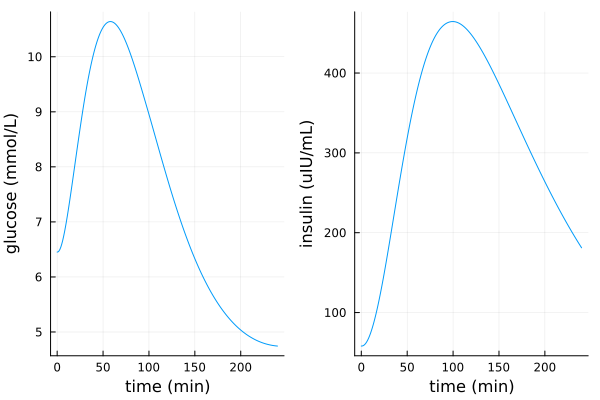

In [4]:
include("./EDES/including.jl")

k5_linear = 0.07
k6_parabolic = 0.02
k6_linear = 0.15
long_time_points = [0,1,3,5,6,8,9]
glucose_time_points = [0,15,30,60,120,180,240]
insulin_time_points = [0,15,30,60,120,240]

# initialise output
outputs_glc = zeros(length(long_time_points), length(glucose_time_points), length(Synthetic_population))
outputs_ins = zeros(length(long_time_points), length(insulin_time_points), length(Synthetic_population))

IDs = zeros(length(Synthetic_population),length(long_time_points))
Health = zeros(length(Synthetic_population))

# loop over the patients
for i in 1:length(Synthetic_population)
    # select the patient
    synthetic_patient = Synthetic_population[i]
    IDs[i,:] .= synthetic_patient.ID
    
    # set a boolean for the health status, even patients are healthy, odd patients are diabetic
    if i % 2 == 0
        Health_bool = true
    else
        Health_bool = false
    end

    Health[i] = Health_bool

    # change the k5 and k6 values
    k5s,k6s, Gbs, I_pl_bs = DiabeticProgression(long_time_points, synthetic_patient,k5_linear,k6_parabolic, k6_linear, Health_bool)

    for j in 1:length(long_time_points)
        # copy the parameter values and the model_copy
        parameter_values_copy = copy(synthetic_patient.ParameterValues)
        model_copy = deepcopy(synthetic_patient.EDES)
        # change the k5 and k6 values
        parameter_values_copy[1] = k5s[j]
        parameter_values_copy[2] = k6s[j]

        # add Gb value
        push!(parameter_values_copy, Gbs[j])
        push!(parameter_values_copy, I_pl_bs[j])
        
        # reassign the names of the parameters to set values for
        model_copy.estimated_params = ["k5","k6","G_b","I_pl_b"]

        # reset the fasting glucose as the actual basal glucose
        model_copy.prob.u0[2] = Gbs[j]
        model_copy.prob.u0[4] = I_pl_bs[j]   

        # plot the meal response
        if i == 1
            plt = PlotMealResponse(model_copy, parameter_values_copy);
            display(plt)
            println(parameter_values_copy)
            #savefig("../Images/SyntheticPatientResponses/SyntheticPatient$i-$j-k5-$k5_linear-k6-$k6_parabolic-k6-$k6_linear.png")
        end
        if j ==4 && i == 1
            LocalSensitivityAnalysis(model_copy, parameter_values_copy, spread = 0.5)
        end

        glc, ins= SelectTimePoints(model_copy,parameter_values_copy, glucose_time_points, insulin_time_points)

        outputs_glc[j,:,i] = glc
        outputs_ins[j,:,i] = ins

    end
end

#save the outputs
save("../Results/SyntheticPatientsOutputs.jld2", 
    "glucose", outputs_glc, 
    "insulin", outputs_ins, 
    "time_G", glucose_time_points,
    "time_I", insulin_time_points,
    "BW", BW,
    "ID", IDs,
    "Health", Health,
    )



# logs
#writedlm("../Images/Logs/SyntheticPatients_$k5_linear,_$k6_parabolic,.txt", [k5s,k6s,k5_linear,k6_parabolic,k6_linear]

10×7 Matrix{Float64}:
  1.0   1.0   1.0   1.0   1.0   1.0   1.0
  2.0   2.0   2.0   2.0   2.0   2.0   2.0
  3.0   3.0   3.0   3.0   3.0   3.0   3.0
  4.0   4.0   4.0   4.0   4.0   4.0   4.0
  5.0   5.0   5.0   5.0   5.0   5.0   5.0
  6.0   6.0   6.0   6.0   6.0   6.0   6.0
  7.0   7.0   7.0   7.0   7.0   7.0   7.0
  8.0   8.0   8.0   8.0   8.0   8.0   8.0
  9.0   9.0   9.0   9.0   9.0   9.0   9.0
 10.0  10.0  10.0  10.0  10.0  10.0  10.0